In [2]:
!nvidia-smi

Thu Feb  1 10:40:10 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:04:00.0 Off |                    0 |
| N/A   40C    P0    57W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   33C    P0    71W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
import os.path as osp

import fcn
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import torch
from torch.autograd import Variable
import torchfcn
from torchfcn.utils import normalize_unit
import tqdm

Populating the interactive namespace from numpy and matplotlib


In [5]:
root = osp.expanduser('~/data/datasets')

## Load data

In [6]:
val_loader = torch.utils.data.DataLoader(
        torchfcn.datasets.VOC2011ClassSeg(
            root, split='seg11valid', transform=True),
        batch_size=1, shuffle=False,
        num_workers=4, pin_memory=True)
n_class = len(val_loader.dataset.class_names)

## Load model

In [7]:
## Initialize model
#if osp.basename(model_file).startswith('fcn32s'):
#    model = torchfcn.models.FCN32s(n_class=21)
#elif osp.basename(model_file).startswith('fcn16s'):
#    model = torchfcn.models.FCN16s(n_class=21)
#elif osp.basename(model_file).startswith('fcn8s'):
#    if osp.basename(model_file).startswith('fcn8s-atonce'):
#        model = torchfcn.models.FCN8sAtOnce(n_class=21)
#    else:
#        model = torchfcn.models.FCN8s(n_class=21)
#else:
#    raise ValueError
model = torchfcn.models.FCN32s(n_class=21)
if torch.cuda.is_available():
    model = model.cuda()

Initializing with gain 1e-08


In [8]:
# Pretrained model
#model_file = torchfcn.models.fcn32s.FCN32s.download()
# My model
model_file = '/zfsauton/home/mbarnes1/deep_spectral_clustering/pytorch-fcn/examples/voc/logs/002_Jan24-20:38:02_mse_lr1e-5_xavier1e-4-norm_VCS-bba5d2d_gpu2/checkpoint.pth.tar'

# Load model
print('==> Loading %s model file: %s' %
      (model.__class__.__name__, model_file))
model_data = torch.load(model_file)
try:
    model.load_state_dict(model_data)
except Exception:
    model.load_state_dict(model_data['model_state_dict'])
model.eval()

==> Loading FCN32s model file: /zfsauton/home/mbarnes1/deep_spectral_clustering/pytorch-fcn/examples/voc/logs/002_Jan24-20:38:02_mse_lr1e-5_xavier1e-4-norm_VCS-bba5d2d_gpu2/checkpoint.pth.tar


FCN32s(
  (conv1_1): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace)
  (conv1_2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2_1): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace)
  (conv2_2): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv3_1): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace)
  (conv3_2): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace)
  (conv3_3): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv4_1):

## Evaluate

In [9]:
from functools import partial
from torch import nn
import torch.nn.functional as F
from torchfcn.cluster.correlation import kwik_cluster, l1_cost, lp_cost
from torchfcn.trainer import cross_entropy2d, MSEAdjacencyLoss
mse_loss = MSEAdjacencyLoss(20000)

In [50]:
## Make predictions
visualizations = []
label_trues, label_preds, all_imgs = [], [], []
loss_cross_entropy = 0
loss_mse = 0
loss_mse_postrounding = 0
#loss_mse_naive_zero = 0  # the loss 
loss_mse_naive_one = 0
n_samples = 0
cost_function = partial(lp_cost, p=100)

for batch_idx, (data, target) in enumerate(val_loader):
    print 'Batch {}'.format(batch_idx)
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    score = model(data)  # 1 x C x H x W  ( I could have H and W flipped)
    batch_size, c, h, w = score.size()
    assert batch_size == 1
    
    n_samples += score.size(0)
    loss_cross_entropy += cross_entropy2d(score, target, size_average=False)
    loss_mse += mse_loss(score, target)
    #loss_mse_naive_zero += mse_loss(Variable(score.data.new(score.size()).fill_(0.0)), target)
    all_one_cluster = Variable(score.data.new(score.size()).fill_(0.0))
    all_one_cluster[:, 1, :, :] = 1.0
    loss_mse_naive_one += mse_loss(all_one_cluster, target)
    
    imgs = data.data.cpu()
    # Softmax rounding
    #lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]  # 1 x h x w array
    
    # KwikCluster rounding
    lbl_pred_tensor = kwik_cluster(normalize_unit(score, dim=1).data.permute(0, 2, 3, 1).contiguous().view(-1, c), cost_function).view(1, h, w)
    lbl_pred = lbl_pred_tensor.cpu().numpy()[:, :, :]
    
    # MSE post-rounding
    n_clusters = torch.max(lbl_pred_tensor) + 1
    lbl_pred_hotone = lbl_pred_tensor.new(batch_size, n_clusters, h, w).float().zero_()
    lbl_pred_hotone.scatter_(1, lbl_pred_tensor.unsqueeze(dim=1), 1)
    loss_mse_postrounding += mse_loss(Variable(lbl_pred_hotone), target)
    
    lbl_true = target.data.cpu()
    for img, lt, lp in zip(imgs, lbl_true, lbl_pred):
        img, lt = val_loader.dataset.untransform(img, lt)
        all_imgs.append(img)
        label_trues.append(lt)
        label_preds.append(lp)
        # TODO: Visualizations (get cv2 installed on server)
        #if len(visualizations) < 9:
        #    viz = fcn.utils.visualize_segmentation(
        #        lbl_pred=lp, lbl_true=lt, img=img, n_class=n_class,
        #        label_names=val_loader.dataset.class_names)
        #    visualizations.append(viz)
loss_cross_entropy /= n_samples
loss_mse /= n_samples
loss_mse_postrounding /= n_samples
#loss_mse_naive_zero /= n_samples
loss_mse_naive_one /= n_samples
loss_cross_entropy = loss_cross_entropy.data[0]
loss_mse = loss_mse.data[0]
loss_mse_postrounding = loss_mse_postrounding.data[0]
#loss_mse_naive_zero = loss_mse_naive_zero.data[0]
loss_mse_naive_one = loss_mse_naive_one.data[0]

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


In [12]:
## Save predictions and labels for later
#import cPickle as pickle
#pickle.dump(label_trues, open( "labels_trues.p", "wb" ) )
#pickle.dump(label_preds, open( "labels_preds.p", "wb" ) )
#pickle.dump(scores, open( "score_list.p", "wb"))

In [51]:
## Metrics
print('''\
Validation cross-entropy loss per sample: {}
Validation MSE (our predictions) loss per sample: {}
Validation MSE post-rounding (our predictions) loss per sample: {}
Validation MSE (naively predict all in same cluster) loss per sample: {}
'''.format(loss_cross_entropy, loss_mse, loss_mse_postrounding, loss_mse_naive_one))
metrics = torchfcn.utils.label_accuracy_score(label_trues, label_preds, n_class=n_class)
metrics = np.array(metrics)
metrics *= 100
print('''\
Accuracy: {0}
Accuracy Class: {1}
Mean IU: {2}
FWAV Accuracy: {3}'''.format(*metrics))

Validation cross-entropy loss per sample: 6116449.5
Validation MSE (our predictions) loss per sample: 0.120421424508
Validation MSE post-rounding (our predictions) loss per sample: 0.174840763211
Validation MSE (naively predict all in same cluster) loss per sample: 0.382142156363

Accuracy: 57.7782955792
Accuracy Class: 7.94688770936
Mean IU: 3.35014071728
FWAV Accuracy: 48.9500330319


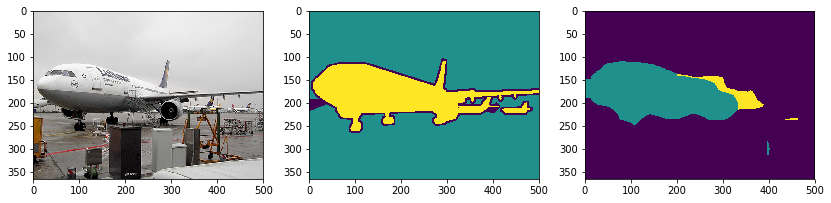

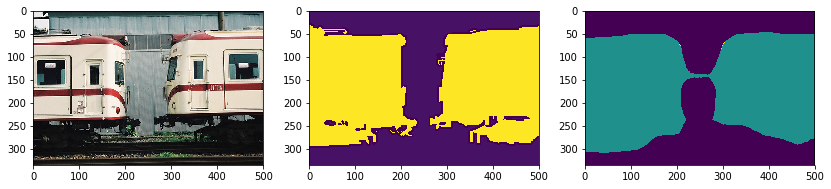

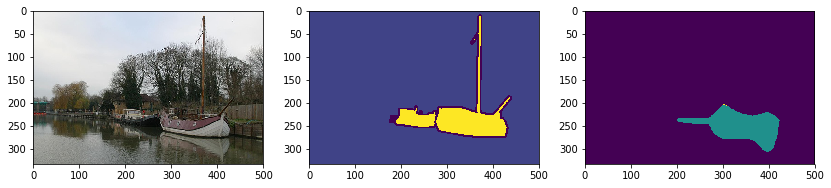

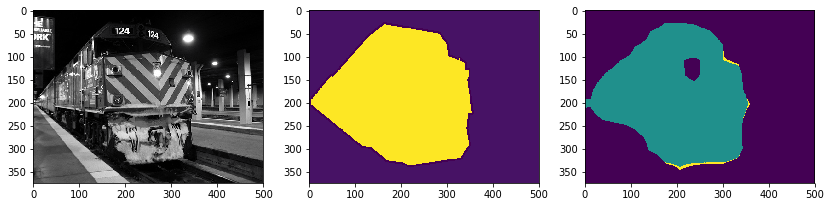

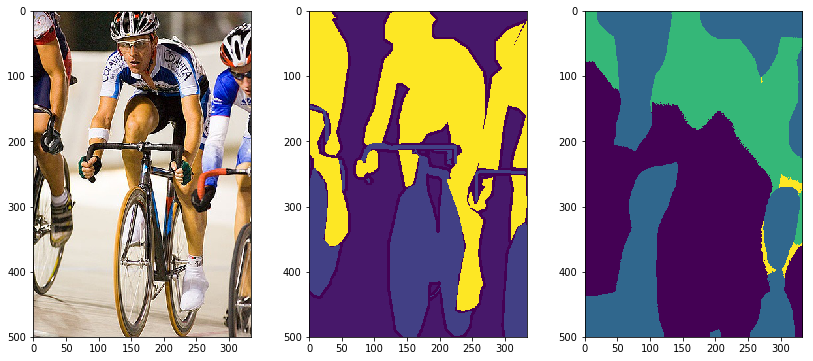

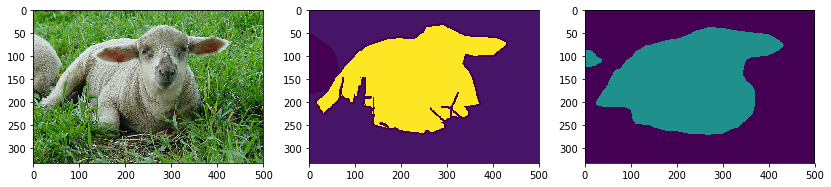

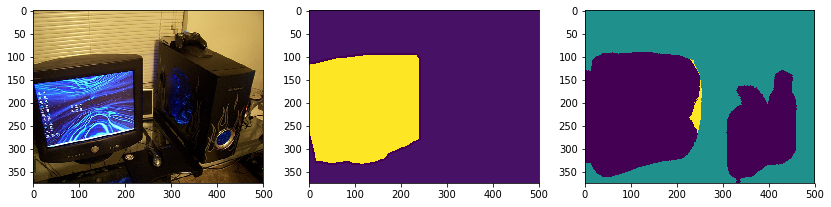

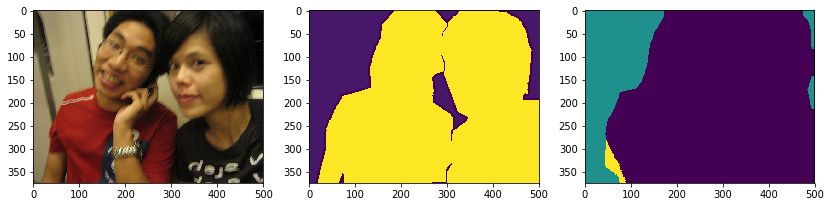

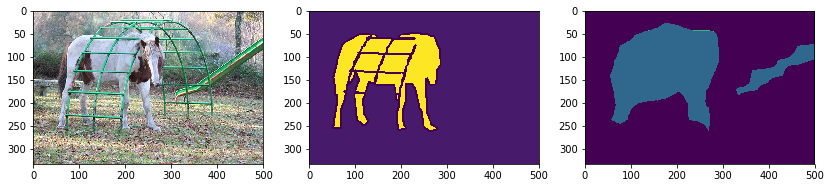

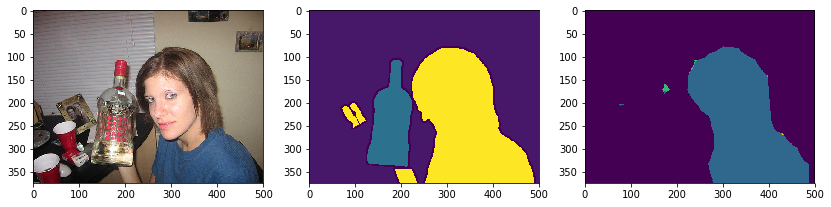

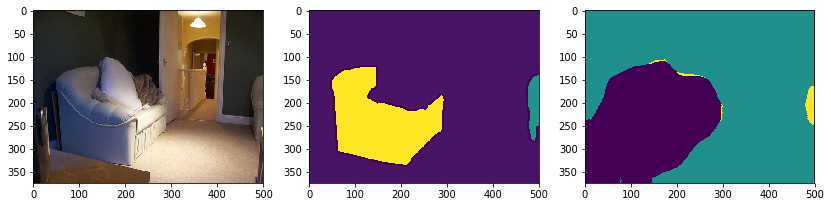

In [52]:
## Visualization
#viz = fcn.utils.get_tile_image(visualizations)
#skimage.io.imsave('viz_evaluate.png', viz)
pylab.rcParams['figure.figsize'] = (14, 6)
for counter, (img, lt, lp) in enumerate(zip(all_imgs, label_trues, label_preds)): # img is h x w x 3. lt and lp is h x w
    # Image
    plt.subplot(131)
    imgplot = plt.imshow(img)
    
    # True labels
    plt.subplot(132)
    plt.imshow(np.array(lt))
    
    # KwikCluster
    plt.subplot(133)
    plt.imshow(np.array(lp))
    plt.show()
    
    if counter >= 10:
        break